# Plant Seedlings Classification - Tensorflow Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image
import cv2

In [2]:
IMG_SIZE = (150, 150)

## Augmentation Functions

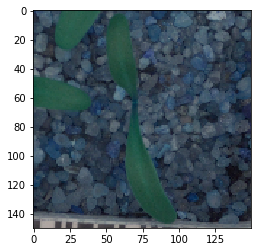

In [3]:
sample = cv2.resize(cv2.imread('../data/SeedlingData/train/Sugar beet/1347ac5ac.png'), IMG_SIZE)
plt.imshow(sample)

In [4]:
def histogram_equalize(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

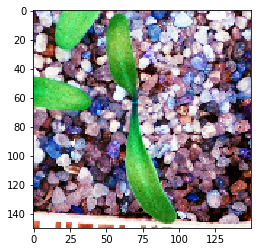

In [5]:
sample = histogram_equalize(sample)
plt.imshow(sample)

In [6]:
def random_rotate(img):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), random.randrange(360), 1)
    img_rotation = cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

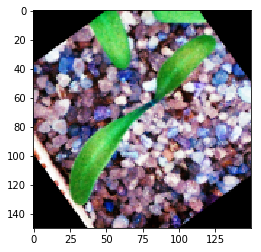

In [7]:
sample = random_rotate(sample)
plt.imshow(sample)

In [8]:
def random_zoom(img):
    x1, y1 = random.randrange(0, 20), random.randrange(0, 20)
    x2, y2 = random.randrange(130, 150), random.randrange(130, 150)
    img = img[y1:y2, x1:x2]
    img = cv2.resize(img, IMG_SIZE)
    return img

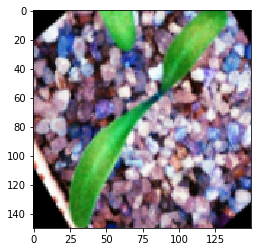

In [9]:
sample = random_zoom(sample)
plt.imshow(sample)

## Data

### - One Hot labels

In [10]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
# print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
# print(onehot_encodeded)

### - Training Data

In [11]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    _=0
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename)
        im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE)))#.ravel()
        training_data.append([im, onehot_encodeded[__]])
#         if _==0:
#             display(Image(filename, width=80, height=80))
#             print(filename)
#             print(onehot_encodeded[__])
#         _+= 1
random.shuffle(training_data)

### - Test Data

In [12]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE))).ravel()
    test_data.append([im, filename.split('/')[-1]])

### Building Model

In [13]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [14]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [15]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [16]:
def max_pool_2by2(x):
    #x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [17]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [18]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [19]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0]*IMG_SIZE[1]*3])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [20]:
#layers
x_image = tf.reshape(x, [-1, IMG_SIZE[0], IMG_SIZE[1], 3])

In [21]:
convo_1 = convolutional_layer(x_image, shape=[5,5,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [22]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [23]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 38*38*64])

In [24]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [25]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [26]:
y_pred = normal_full_layer(full_one_dropout, 12)

In [27]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [28]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Batch Loader

In [30]:
def load_batch(size):
    batch_x, batch_y = [],[]
    for _ in range(size):
            rand_val = random.randrange(0,len(test_data))
            batch_x.append(random_zoom(random_rotate(training_data[rand_val][0])).ravel())
            batch_y.append(training_data[rand_val][1])
    return batch_x, batch_y    

## Runing Session

In [31]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
steps = 160000

In [33]:
plot_data = []
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            plot_data.append(temp_plot)
            print('ON STEP: {} - COST: {} '.format(i, temp_plot))
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

ON STEP: 0 - COST: 69511.5625 
ON STEP: 100 - COST: 26.184452056884766 
ON STEP: 200 - COST: 6.837431907653809 
ON STEP: 300 - COST: 2.9575419425964355 
ON STEP: 400 - COST: 2.3798952102661133 
ON STEP: 500 - COST: 2.653585910797119 
ON STEP: 600 - COST: 2.4138331413269043 
ON STEP: 700 - COST: 2.4243032932281494 
ON STEP: 800 - COST: 2.4308383464813232 
ON STEP: 900 - COST: 2.4621987342834473 
ON STEP: 1000 - COST: 2.4276340007781982 
ON STEP: 1100 - COST: 2.4388794898986816 
ON STEP: 1200 - COST: 2.3773961067199707 
ON STEP: 1300 - COST: 2.3427047729492188 
ON STEP: 1400 - COST: 2.34359073638916 
ON STEP: 1500 - COST: 2.3559212684631348 
ON STEP: 1600 - COST: 2.5520999431610107 
ON STEP: 1700 - COST: 2.409226417541504 
ON STEP: 1800 - COST: 2.2380473613739014 
ON STEP: 1900 - COST: 2.2808732986450195 
ON STEP: 2000 - COST: 2.4054157733917236 
ON STEP: 2100 - COST: 2.258887529373169 
ON STEP: 2200 - COST: 2.368198871612549 
ON STEP: 2300 - COST: 2.238185405731201 
ON STEP: 2400 - COST

ON STEP: 19600 - COST: 2.2087759971618652 
ON STEP: 19700 - COST: 1.9762649536132812 
ON STEP: 19800 - COST: 2.231534242630005 
ON STEP: 19900 - COST: 2.2923460006713867 
ON STEP: 20000 - COST: 2.1949589252471924 
ON STEP: 20100 - COST: 2.116065263748169 
ON STEP: 20200 - COST: 2.1038451194763184 
ON STEP: 20300 - COST: 2.3245890140533447 
ON STEP: 20400 - COST: 2.0417728424072266 
ON STEP: 20500 - COST: 2.1685776710510254 
ON STEP: 20600 - COST: 2.08168888092041 
ON STEP: 20700 - COST: 2.0746586322784424 
ON STEP: 20800 - COST: 2.3130805492401123 
ON STEP: 20900 - COST: 2.1637630462646484 
ON STEP: 21000 - COST: 2.0266470909118652 
ON STEP: 21100 - COST: 2.1913461685180664 
ON STEP: 21200 - COST: 2.023103952407837 
ON STEP: 21300 - COST: 2.1403167247772217 
ON STEP: 21400 - COST: 2.1754860877990723 
ON STEP: 21500 - COST: 2.1739888191223145 
ON STEP: 21600 - COST: 2.088320732116699 
ON STEP: 21700 - COST: 2.124385356903076 
ON STEP: 21800 - COST: 2.094106912612915 
ON STEP: 21900 - CO

ON STEP: 38900 - COST: 2.083873748779297 
ON STEP: 39000 - COST: 1.8574413061141968 
ON STEP: 39100 - COST: 2.1109766960144043 
ON STEP: 39200 - COST: 2.0713348388671875 
ON STEP: 39300 - COST: 2.116304397583008 
ON STEP: 39400 - COST: 1.9765805006027222 
ON STEP: 39500 - COST: 2.17672061920166 
ON STEP: 39600 - COST: 2.064096212387085 
ON STEP: 39700 - COST: 2.203016757965088 
ON STEP: 39800 - COST: 1.9519357681274414 
ON STEP: 39900 - COST: 2.0463342666625977 
ON STEP: 40000 - COST: 2.1792476177215576 
ON STEP: 40100 - COST: 2.08644437789917 
ON STEP: 40200 - COST: 2.023249626159668 
ON STEP: 40300 - COST: 1.933133602142334 
ON STEP: 40400 - COST: 2.1329567432403564 
ON STEP: 40500 - COST: 2.1554360389709473 
ON STEP: 40600 - COST: 2.225738525390625 
ON STEP: 40700 - COST: 2.1915276050567627 
ON STEP: 40800 - COST: 2.114919424057007 
ON STEP: 40900 - COST: 2.2492337226867676 
ON STEP: 41000 - COST: 2.0129899978637695 
ON STEP: 41100 - COST: 2.0772223472595215 
ON STEP: 41200 - COST: 

ON STEP: 58200 - COST: 1.223623275756836 
ON STEP: 58300 - COST: 1.051000714302063 
ON STEP: 58400 - COST: 1.4159249067306519 
ON STEP: 58500 - COST: 1.296669602394104 
ON STEP: 58600 - COST: 1.2652606964111328 
ON STEP: 58700 - COST: 1.2203552722930908 
ON STEP: 58800 - COST: 1.3204095363616943 
ON STEP: 58900 - COST: 1.5295637845993042 
ON STEP: 59000 - COST: 1.1697473526000977 
ON STEP: 59100 - COST: 1.3039054870605469 
ON STEP: 59200 - COST: 1.141038179397583 
ON STEP: 59300 - COST: 1.3116660118103027 
ON STEP: 59400 - COST: 1.259637475013733 
ON STEP: 59500 - COST: 1.1993825435638428 
ON STEP: 59600 - COST: 1.2411447763442993 
ON STEP: 59700 - COST: 1.1196894645690918 
ON STEP: 59800 - COST: 1.376797080039978 
ON STEP: 59900 - COST: 0.9994758367538452 
ON STEP: 60000 - COST: 1.4168388843536377 
ON STEP: 60100 - COST: 1.0655128955841064 
ON STEP: 60200 - COST: 1.3779377937316895 
ON STEP: 60300 - COST: 1.038438081741333 
ON STEP: 60400 - COST: 1.1916406154632568 
ON STEP: 60500 - C

ON STEP: 77400 - COST: 0.6309875845909119 
ON STEP: 77500 - COST: 0.6119530200958252 
ON STEP: 77600 - COST: 0.455149382352829 
ON STEP: 77700 - COST: 0.7359143495559692 
ON STEP: 77800 - COST: 0.7590305805206299 
ON STEP: 77900 - COST: 0.7637567520141602 
ON STEP: 78000 - COST: 0.5430417060852051 
ON STEP: 78100 - COST: 0.5403257608413696 
ON STEP: 78200 - COST: 0.7755143046379089 
ON STEP: 78300 - COST: 1.0102815628051758 
ON STEP: 78400 - COST: 0.8873047232627869 
ON STEP: 78500 - COST: 0.6986687183380127 
ON STEP: 78600 - COST: 0.7524387240409851 
ON STEP: 78700 - COST: 0.8073365688323975 
ON STEP: 78800 - COST: 0.5660962462425232 
ON STEP: 78900 - COST: 0.7344309091567993 
ON STEP: 79000 - COST: 0.8346101641654968 
ON STEP: 79100 - COST: 0.9492624402046204 
ON STEP: 79200 - COST: 0.7460384964942932 
ON STEP: 79300 - COST: 0.7302488088607788 
ON STEP: 79400 - COST: 0.6012316942214966 
ON STEP: 79500 - COST: 0.9148073196411133 
ON STEP: 79600 - COST: 0.5900516510009766 
ON STEP: 797

ON STEP: 96500 - COST: 0.5632416009902954 
ON STEP: 96600 - COST: 0.636656641960144 
ON STEP: 96700 - COST: 0.5798144340515137 
ON STEP: 96800 - COST: 0.6903209686279297 
ON STEP: 96900 - COST: 0.33285555243492126 
ON STEP: 97000 - COST: 0.40520215034484863 
ON STEP: 97100 - COST: 0.4680037200450897 
ON STEP: 97200 - COST: 0.5475465059280396 
ON STEP: 97300 - COST: 0.6409428119659424 
ON STEP: 97400 - COST: 0.8075027465820312 
ON STEP: 97500 - COST: 0.26795607805252075 
ON STEP: 97600 - COST: 0.43357014656066895 
ON STEP: 97700 - COST: 0.3220958113670349 
ON STEP: 97800 - COST: 0.7578739523887634 
ON STEP: 97900 - COST: 0.42888203263282776 
ON STEP: 98000 - COST: 0.6884180307388306 
ON STEP: 98100 - COST: 0.5277412533760071 
ON STEP: 98200 - COST: 0.688029408454895 
ON STEP: 98300 - COST: 0.5597581267356873 
ON STEP: 98400 - COST: 0.5591391324996948 
ON STEP: 98500 - COST: 0.8138445019721985 
ON STEP: 98600 - COST: 0.9472927451133728 
ON STEP: 98700 - COST: 0.8124582171440125 
ON STEP:

ON STEP: 115200 - COST: 0.3729425072669983 
ON STEP: 115300 - COST: 0.436003714799881 
ON STEP: 115400 - COST: 0.45908933877944946 
ON STEP: 115500 - COST: 0.272918164730072 
ON STEP: 115600 - COST: 0.5396909713745117 
ON STEP: 115700 - COST: 0.6659727096557617 
ON STEP: 115800 - COST: 0.39098280668258667 
ON STEP: 115900 - COST: 0.5886996984481812 
ON STEP: 116000 - COST: 0.40176650881767273 
ON STEP: 116100 - COST: 0.8079116940498352 
ON STEP: 116200 - COST: 0.8344223499298096 
ON STEP: 116300 - COST: 0.5950616598129272 
ON STEP: 116400 - COST: 0.488953560590744 
ON STEP: 116500 - COST: 0.5325292348861694 
ON STEP: 116600 - COST: 0.42875444889068604 
ON STEP: 116700 - COST: 0.5686371326446533 
ON STEP: 116800 - COST: 0.25370359420776367 
ON STEP: 116900 - COST: 0.4003913700580597 
ON STEP: 117000 - COST: 0.39760154485702515 
ON STEP: 117100 - COST: 0.6706876754760742 
ON STEP: 117200 - COST: 0.4279177486896515 
ON STEP: 117300 - COST: 0.545955240726471 
ON STEP: 117400 - COST: 0.4408

ON STEP: 133800 - COST: 0.41973572969436646 
ON STEP: 133900 - COST: 0.5455881953239441 
ON STEP: 134000 - COST: 0.4507507085800171 
ON STEP: 134100 - COST: 0.43188953399658203 
ON STEP: 134200 - COST: 0.4891010820865631 
ON STEP: 134300 - COST: 0.45382142066955566 
ON STEP: 134400 - COST: 0.45139822363853455 
ON STEP: 134500 - COST: 1.0468308925628662 
ON STEP: 134600 - COST: 0.433657705783844 
ON STEP: 134700 - COST: 0.5467473864555359 
ON STEP: 134800 - COST: 0.5543352961540222 
ON STEP: 134900 - COST: 0.6162375211715698 
ON STEP: 135000 - COST: 0.5314698815345764 
ON STEP: 135100 - COST: 0.43927210569381714 
ON STEP: 135200 - COST: 0.7450968027114868 
ON STEP: 135300 - COST: 1.024324655532837 
ON STEP: 135400 - COST: 0.4489089548587799 
ON STEP: 135500 - COST: 0.3147798478603363 
ON STEP: 135600 - COST: 0.5326746106147766 
ON STEP: 135700 - COST: 0.43855446577072144 
ON STEP: 135800 - COST: 0.38387855887413025 
ON STEP: 135900 - COST: 0.45536574721336365 
ON STEP: 136000 - COST: 0.

ON STEP: 152400 - COST: 0.5818763971328735 
ON STEP: 152500 - COST: 0.7000600099563599 
ON STEP: 152600 - COST: 0.8173083662986755 
ON STEP: 152700 - COST: 0.28795376420021057 
ON STEP: 152800 - COST: 0.4615945816040039 
ON STEP: 152900 - COST: 0.4618518352508545 
ON STEP: 153000 - COST: 0.5340846180915833 
ON STEP: 153100 - COST: 0.7994558811187744 
ON STEP: 153200 - COST: 0.42086029052734375 
ON STEP: 153300 - COST: 0.5485022068023682 
ON STEP: 153400 - COST: 0.5233035087585449 
ON STEP: 153500 - COST: 0.2877745032310486 
ON STEP: 153600 - COST: 0.6740484237670898 
ON STEP: 153700 - COST: 0.32367807626724243 
ON STEP: 153800 - COST: 0.3259231448173523 
ON STEP: 153900 - COST: 0.27934738993644714 
ON STEP: 154000 - COST: 0.4143212139606476 
ON STEP: 154100 - COST: 0.3848112225532532 
ON STEP: 154200 - COST: 0.26327717304229736 
ON STEP: 154300 - COST: 0.3836320638656616 
ON STEP: 154400 - COST: 0.562690794467926 
ON STEP: 154500 - COST: 0.2841978371143341 
ON STEP: 154600 - COST: 0.69

ON STEP: 171000 - COST: 0.5704728364944458 
ON STEP: 171100 - COST: 0.4563925862312317 
ON STEP: 171200 - COST: 0.5069096088409424 
ON STEP: 171300 - COST: 0.4672397971153259 
ON STEP: 171400 - COST: 0.5103045701980591 
ON STEP: 171500 - COST: 0.45289847254753113 
ON STEP: 171600 - COST: 0.5530660152435303 
ON STEP: 171700 - COST: 0.22889794409275055 
ON STEP: 171800 - COST: 0.6344842910766602 
ON STEP: 171900 - COST: 0.3937232494354248 
ON STEP: 172000 - COST: 0.46581965684890747 
ON STEP: 172100 - COST: 0.2876932621002197 
ON STEP: 172200 - COST: 0.28256890177726746 
ON STEP: 172300 - COST: 0.5021624565124512 
ON STEP: 172400 - COST: 0.45379242300987244 
ON STEP: 172500 - COST: 0.33834049105644226 
ON STEP: 172600 - COST: 0.6637715697288513 
ON STEP: 172700 - COST: 0.5646325349807739 
ON STEP: 172800 - COST: 0.5200587511062622 
ON STEP: 172900 - COST: 0.5171196460723877 
ON STEP: 173000 - COST: 0.3534943461418152 
ON STEP: 173100 - COST: 0.3203827738761902 
ON STEP: 173200 - COST: 0.

ON STEP: 189600 - COST: 0.4156506061553955 
ON STEP: 189700 - COST: 0.31338873505592346 
ON STEP: 189800 - COST: 0.34494125843048096 
ON STEP: 189900 - COST: 0.37310123443603516 
ON STEP: 190000 - COST: 0.6489199995994568 
ON STEP: 190100 - COST: 0.4004822373390198 
ON STEP: 190200 - COST: 0.5873230695724487 
ON STEP: 190300 - COST: 0.4328983426094055 
ON STEP: 190400 - COST: 0.23768949508666992 
ON STEP: 190500 - COST: 0.41172313690185547 
ON STEP: 190600 - COST: 0.4674569070339203 
ON STEP: 190700 - COST: 0.7217140197753906 
ON STEP: 190800 - COST: 0.4488701820373535 
ON STEP: 190900 - COST: 0.43881916999816895 
ON STEP: 191000 - COST: 0.4091089367866516 
ON STEP: 191100 - COST: 0.39634495973587036 
ON STEP: 191200 - COST: 0.7525492310523987 
ON STEP: 191300 - COST: 0.6380780339241028 
ON STEP: 191400 - COST: 0.5583697557449341 
ON STEP: 191500 - COST: 0.26787102222442627 
ON STEP: 191600 - COST: 0.548245906829834 
ON STEP: 191700 - COST: 0.6404176950454712 
ON STEP: 191800 - COST: 0

ON STEP: 208200 - COST: 0.5979399681091309 
ON STEP: 208300 - COST: 0.4972429871559143 
ON STEP: 208400 - COST: 0.45985543727874756 
ON STEP: 208500 - COST: 0.43942227959632874 
ON STEP: 208600 - COST: 0.4223015606403351 
ON STEP: 208700 - COST: 0.46308112144470215 
ON STEP: 208800 - COST: 0.5648213028907776 
ON STEP: 208900 - COST: 0.26081180572509766 
ON STEP: 209000 - COST: 0.28912872076034546 
ON STEP: 209100 - COST: 0.4842143654823303 
ON STEP: 209200 - COST: 0.6428983807563782 
ON STEP: 209300 - COST: 0.5036743879318237 
ON STEP: 209400 - COST: 0.5151759386062622 
ON STEP: 209500 - COST: 0.4879644513130188 
ON STEP: 209600 - COST: 0.21216236054897308 
ON STEP: 209700 - COST: 0.16817305982112885 
ON STEP: 209800 - COST: 0.4707587957382202 
ON STEP: 209900 - COST: 0.5718809962272644 
ON STEP: 210000 - COST: 0.3656795918941498 
ON STEP: 210100 - COST: 0.6765209436416626 
ON STEP: 210200 - COST: 0.6815712451934814 
ON STEP: 210300 - COST: 0.4195536971092224 
ON STEP: 210400 - COST: 0

ON STEP: 226800 - COST: 0.4245751202106476 
ON STEP: 226900 - COST: 0.49080905318260193 
ON STEP: 227000 - COST: 0.24353452026844025 
ON STEP: 227100 - COST: 0.2292023003101349 
ON STEP: 227200 - COST: 0.4354439675807953 
ON STEP: 227300 - COST: 0.32492533326148987 
ON STEP: 227400 - COST: 0.5553365349769592 
ON STEP: 227500 - COST: 0.2086133062839508 
ON STEP: 227600 - COST: 0.4607827365398407 
ON STEP: 227700 - COST: 0.5757102370262146 
ON STEP: 227800 - COST: 0.8320854902267456 
ON STEP: 227900 - COST: 0.4028114080429077 
ON STEP: 228000 - COST: 0.35195815563201904 
ON STEP: 228100 - COST: 0.33014073967933655 
ON STEP: 228200 - COST: 0.38235288858413696 
ON STEP: 228300 - COST: 0.7065834999084473 
ON STEP: 228400 - COST: 0.3541513681411743 
ON STEP: 228500 - COST: 0.26792094111442566 
ON STEP: 228600 - COST: 0.3442752957344055 
ON STEP: 228700 - COST: 0.2400144338607788 
ON STEP: 228800 - COST: 0.5193623900413513 
ON STEP: 228900 - COST: 0.31586676836013794 
ON STEP: 229000 - COST: 

ON STEP: 245300 - COST: 0.44322410225868225 
ON STEP: 245400 - COST: 0.5064839124679565 
ON STEP: 245500 - COST: 0.4028545618057251 
ON STEP: 245600 - COST: 0.34273794293403625 
ON STEP: 245700 - COST: 0.4180050790309906 
ON STEP: 245800 - COST: 0.38365262746810913 
ON STEP: 245900 - COST: 0.39002835750579834 
ON STEP: 246000 - COST: 0.5766053199768066 
ON STEP: 246100 - COST: 0.5473325252532959 
ON STEP: 246200 - COST: 0.5046720504760742 
ON STEP: 246300 - COST: 0.39578232169151306 
ON STEP: 246400 - COST: 0.3828372061252594 
ON STEP: 246500 - COST: 0.6318941116333008 
ON STEP: 246600 - COST: 0.29283010959625244 
ON STEP: 246700 - COST: 0.5715308785438538 
ON STEP: 246800 - COST: 0.36343589425086975 
ON STEP: 246900 - COST: 0.3067150115966797 
ON STEP: 247000 - COST: 0.5926740169525146 
ON STEP: 247100 - COST: 0.42379632592201233 
ON STEP: 247200 - COST: 0.421182781457901 
ON STEP: 247300 - COST: 0.589077353477478 
ON STEP: 247400 - COST: 0.6756067276000977 
ON STEP: 247500 - COST: 0.

ON STEP: 263900 - COST: 0.4508156180381775 
ON STEP: 264000 - COST: 0.8315937519073486 
ON STEP: 264100 - COST: 0.4012763202190399 
ON STEP: 264200 - COST: 0.2542892098426819 
ON STEP: 264300 - COST: 0.5993732213973999 
ON STEP: 264400 - COST: 0.4326242208480835 
ON STEP: 264500 - COST: 0.36216917634010315 
ON STEP: 264600 - COST: 0.2884722352027893 
ON STEP: 264700 - COST: 0.40075957775115967 
ON STEP: 264800 - COST: 0.3674551844596863 
ON STEP: 264900 - COST: 0.7393589615821838 
ON STEP: 265000 - COST: 0.5764012932777405 
ON STEP: 265100 - COST: 0.4803667366504669 
ON STEP: 265200 - COST: 0.24563351273536682 
ON STEP: 265300 - COST: 0.683397650718689 
ON STEP: 265400 - COST: 0.38903170824050903 
ON STEP: 265500 - COST: 0.4096257984638214 
ON STEP: 265600 - COST: 0.5311133861541748 
ON STEP: 265700 - COST: 0.6496078968048096 
ON STEP: 265800 - COST: 0.3616804778575897 
ON STEP: 265900 - COST: 0.3931332230567932 
ON STEP: 266000 - COST: 0.321582555770874 
ON STEP: 266100 - COST: 0.1970

ON STEP: 282500 - COST: 0.3113061487674713 
ON STEP: 282600 - COST: 0.6014145612716675 
ON STEP: 282700 - COST: 1.233826994895935 
ON STEP: 282800 - COST: 0.4595699608325958 
ON STEP: 282900 - COST: 0.6888870000839233 
ON STEP: 283000 - COST: 0.6578619480133057 
ON STEP: 283100 - COST: 0.7105827331542969 
ON STEP: 283200 - COST: 0.8666905164718628 
ON STEP: 283300 - COST: 0.3398406505584717 
ON STEP: 283400 - COST: 0.6208273768424988 
ON STEP: 283500 - COST: 0.31343796849250793 
ON STEP: 283600 - COST: 0.542424738407135 
ON STEP: 283700 - COST: 0.5509945750236511 
ON STEP: 283800 - COST: 0.5219238996505737 
ON STEP: 283900 - COST: 0.3821152448654175 
ON STEP: 284000 - COST: 0.3440811038017273 
ON STEP: 284100 - COST: 0.5060606598854065 
ON STEP: 284200 - COST: 0.45269522070884705 
ON STEP: 284300 - COST: 1.003800630569458 
ON STEP: 284400 - COST: 0.5085292458534241 
ON STEP: 284500 - COST: 0.22473211586475372 
ON STEP: 284600 - COST: 0.09702837467193604 
ON STEP: 284700 - COST: 1.05561

ON STEP: 301100 - COST: 0.4605534076690674 
ON STEP: 301200 - COST: 0.3182222843170166 
ON STEP: 301300 - COST: 0.24627119302749634 
ON STEP: 301400 - COST: 0.24155521392822266 
ON STEP: 301500 - COST: 0.516621470451355 
ON STEP: 301600 - COST: 0.5559757351875305 
ON STEP: 301700 - COST: 0.24011364579200745 
ON STEP: 301800 - COST: 0.3292718231678009 
ON STEP: 301900 - COST: 0.5622501373291016 
ON STEP: 302000 - COST: 0.29802650213241577 
ON STEP: 302100 - COST: 0.6791481375694275 
ON STEP: 302200 - COST: 0.3917282223701477 
ON STEP: 302300 - COST: 0.14631503820419312 
ON STEP: 302400 - COST: 0.2475648820400238 
ON STEP: 302500 - COST: 0.6918681859970093 
ON STEP: 302600 - COST: 0.25897184014320374 
ON STEP: 302700 - COST: 0.5244643092155457 
ON STEP: 302800 - COST: 0.5513256788253784 
ON STEP: 302900 - COST: 0.42360448837280273 
ON STEP: 303000 - COST: 0.507300078868866 
ON STEP: 303100 - COST: 0.5405770540237427 
ON STEP: 303200 - COST: 0.26164793968200684 
ON STEP: 303300 - COST: 0.

ON STEP: 319700 - COST: 0.42755433917045593 
ON STEP: 319800 - COST: 0.43246543407440186 
ON STEP: 319900 - COST: 0.3707980513572693 
ON STEP: 320000 - COST: 0.3844083547592163 
ON STEP: 320100 - COST: 0.715641975402832 
ON STEP: 320200 - COST: 0.33516478538513184 
ON STEP: 320300 - COST: 0.2505027651786804 
ON STEP: 320400 - COST: 0.5877581834793091 
ON STEP: 320500 - COST: 0.568432092666626 
ON STEP: 320600 - COST: 0.48079603910446167 
ON STEP: 320700 - COST: 0.4578815996646881 
ON STEP: 320800 - COST: 0.27651137113571167 
ON STEP: 320900 - COST: 0.6040579080581665 
ON STEP: 321000 - COST: 0.6853147745132446 
ON STEP: 321100 - COST: 0.29363852739334106 
ON STEP: 321200 - COST: 0.850574791431427 
ON STEP: 321300 - COST: 0.36327677965164185 
ON STEP: 321400 - COST: 0.6798017621040344 
ON STEP: 321500 - COST: 0.38328105211257935 
ON STEP: 321600 - COST: 0.5323553085327148 
ON STEP: 321700 - COST: 0.3518171012401581 
ON STEP: 321800 - COST: 0.6473271250724792 
ON STEP: 321900 - COST: 0.5

ON STEP: 338200 - COST: 0.6528574824333191 
ON STEP: 338300 - COST: 0.2801333963871002 
ON STEP: 338400 - COST: 0.38779401779174805 
ON STEP: 338500 - COST: 0.602637767791748 
ON STEP: 338600 - COST: 0.4953964352607727 
ON STEP: 338700 - COST: 1.0710290670394897 
ON STEP: 338800 - COST: 0.17904309928417206 
ON STEP: 338900 - COST: 0.3843543827533722 
ON STEP: 339000 - COST: 0.7856228351593018 
ON STEP: 339100 - COST: 0.36116644740104675 
ON STEP: 339200 - COST: 0.26861631870269775 
ON STEP: 339300 - COST: 0.48906633257865906 
ON STEP: 339400 - COST: 0.3635503947734833 
ON STEP: 339500 - COST: 0.7162244915962219 
ON STEP: 339600 - COST: 0.39322182536125183 
ON STEP: 339700 - COST: 0.2506716251373291 
ON STEP: 339800 - COST: 0.5316060781478882 
ON STEP: 339900 - COST: 0.37374070286750793 
ON STEP: 340000 - COST: 0.3602069914340973 
ON STEP: 340100 - COST: 0.5209880471229553 
ON STEP: 340200 - COST: 0.4501481056213379 
ON STEP: 340300 - COST: 0.29588639736175537 
ON STEP: 340400 - COST: 0

ON STEP: 356800 - COST: 0.8226421475410461 
ON STEP: 356900 - COST: 0.6378016471862793 
ON STEP: 357000 - COST: 0.1483057290315628 
ON STEP: 357100 - COST: 1.2797260284423828 
ON STEP: 357200 - COST: 0.34873899817466736 
ON STEP: 357300 - COST: 0.6550672054290771 
ON STEP: 357400 - COST: 0.5082079768180847 
ON STEP: 357500 - COST: 0.3368496596813202 
ON STEP: 357600 - COST: 0.3509165048599243 
ON STEP: 357700 - COST: 0.4370313286781311 
ON STEP: 357800 - COST: 0.5056031346321106 
ON STEP: 357900 - COST: 1.027551531791687 
ON STEP: 358000 - COST: 0.9418929815292358 
ON STEP: 358100 - COST: 0.6173365712165833 
ON STEP: 358200 - COST: 0.6654589176177979 
ON STEP: 358300 - COST: 0.45346900820732117 
ON STEP: 358400 - COST: 0.8607119917869568 
ON STEP: 358500 - COST: 0.3791365623474121 
ON STEP: 358600 - COST: 0.26402294635772705 
ON STEP: 358700 - COST: 0.4619331359863281 
ON STEP: 358800 - COST: 0.5312308073043823 
ON STEP: 358900 - COST: 0.25212472677230835 
ON STEP: 359000 - COST: 0.550

ON STEP: 375400 - COST: 0.4343695044517517 
ON STEP: 375500 - COST: 0.4552820324897766 
ON STEP: 375600 - COST: 0.5788382887840271 
ON STEP: 375700 - COST: 0.25210195779800415 
ON STEP: 375800 - COST: 0.407551109790802 
ON STEP: 375900 - COST: 0.4379592537879944 
ON STEP: 376000 - COST: 0.4787184000015259 
ON STEP: 376100 - COST: 0.5670128464698792 
ON STEP: 376200 - COST: 0.2580764889717102 
ON STEP: 376300 - COST: 0.5590236186981201 
ON STEP: 376400 - COST: 0.5149185657501221 
ON STEP: 376500 - COST: 0.5208802223205566 
ON STEP: 376600 - COST: 0.3364863395690918 
ON STEP: 376700 - COST: 0.3580411374568939 
ON STEP: 376800 - COST: 0.6969754695892334 
ON STEP: 376900 - COST: 0.5353677272796631 
ON STEP: 377000 - COST: 0.2644730806350708 
ON STEP: 377100 - COST: 0.44834139943122864 
ON STEP: 377200 - COST: 0.4270271956920624 
ON STEP: 377300 - COST: 0.2021140605211258 
ON STEP: 377400 - COST: 0.37213611602783203 
ON STEP: 377500 - COST: 0.48669376969337463 
ON STEP: 377600 - COST: 0.924

ON STEP: 394000 - COST: 0.27847713232040405 
ON STEP: 394100 - COST: 1.018442153930664 
ON STEP: 394200 - COST: 0.3493776321411133 
ON STEP: 394300 - COST: 0.6702824831008911 
ON STEP: 394400 - COST: 0.2532406449317932 
ON STEP: 394500 - COST: 0.48559167981147766 
ON STEP: 394600 - COST: 0.5509446859359741 
ON STEP: 394700 - COST: 0.20698150992393494 
ON STEP: 394800 - COST: 0.427548885345459 
ON STEP: 394900 - COST: 0.5450261235237122 
ON STEP: 395000 - COST: 0.3491142690181732 
ON STEP: 395100 - COST: 0.48246243596076965 
ON STEP: 395200 - COST: 2.834944248199463 
ON STEP: 395300 - COST: 0.43595150113105774 
ON STEP: 395400 - COST: 0.3187568187713623 
ON STEP: 395500 - COST: 0.4201880097389221 
ON STEP: 395600 - COST: 0.12257540971040726 
ON STEP: 395700 - COST: 0.5341717004776001 
ON STEP: 395800 - COST: 0.7281584739685059 
ON STEP: 395900 - COST: 0.45701834559440613 
ON STEP: 396000 - COST: 0.2077341377735138 
ON STEP: 396100 - COST: 0.5554178953170776 
ON STEP: 396200 - COST: 1.11

ON STEP: 412600 - COST: 0.34372076392173767 
ON STEP: 412700 - COST: 0.5843842625617981 
ON STEP: 412800 - COST: 0.7871338725090027 
ON STEP: 412900 - COST: 1.5081571340560913 
ON STEP: 413000 - COST: 1.3843562602996826 
ON STEP: 413100 - COST: 0.6794837117195129 
ON STEP: 413200 - COST: 0.7247927188873291 
ON STEP: 413300 - COST: 0.5651054382324219 
ON STEP: 413400 - COST: 0.3589836359024048 
ON STEP: 413500 - COST: 0.7844721674919128 
ON STEP: 413600 - COST: 0.5756844282150269 
ON STEP: 413700 - COST: 0.7708643674850464 
ON STEP: 413800 - COST: 0.5057167410850525 
ON STEP: 413900 - COST: 0.3467472195625305 
ON STEP: 414000 - COST: 0.4489913880825043 
ON STEP: 414100 - COST: 0.680884599685669 
ON STEP: 414200 - COST: 0.275166392326355 
ON STEP: 414300 - COST: 0.5590439438819885 
ON STEP: 414400 - COST: 0.2148340791463852 
ON STEP: 414500 - COST: 0.7281827330589294 
ON STEP: 414600 - COST: 0.3319331407546997 
ON STEP: 414700 - COST: 0.41953936219215393 
ON STEP: 414800 - COST: 0.383288

ON STEP: 431200 - COST: 0.45191094279289246 
ON STEP: 431300 - COST: 0.39643406867980957 
ON STEP: 431400 - COST: 0.5039281249046326 
ON STEP: 431500 - COST: 0.5881364345550537 
ON STEP: 431600 - COST: 0.7434452772140503 
ON STEP: 431700 - COST: 0.3754154145717621 
ON STEP: 431800 - COST: 0.26869264245033264 
ON STEP: 431900 - COST: 0.5050416588783264 
ON STEP: 432000 - COST: 0.3273729681968689 
ON STEP: 432100 - COST: 0.6408917307853699 
ON STEP: 432200 - COST: 0.7494834065437317 
ON STEP: 432300 - COST: 0.5358835458755493 
ON STEP: 432400 - COST: 0.5301119089126587 
ON STEP: 432500 - COST: 0.46808961033821106 
ON STEP: 432600 - COST: 0.33703842759132385 
ON STEP: 432700 - COST: 0.3734547793865204 
ON STEP: 432800 - COST: 0.2602624297142029 
ON STEP: 432900 - COST: 0.465234637260437 
ON STEP: 433000 - COST: 0.4257897734642029 
ON STEP: 433100 - COST: 0.4879148304462433 
ON STEP: 433200 - COST: 0.37904930114746094 
ON STEP: 433300 - COST: 0.5709955096244812 
ON STEP: 433400 - COST: 0.5

ON STEP: 449800 - COST: 0.9258213639259338 
ON STEP: 449900 - COST: 1.0327175855636597 
ON STEP: 450000 - COST: 0.773357629776001 
ON STEP: 450100 - COST: 0.7912150025367737 
ON STEP: 450200 - COST: 0.6253833174705505 
ON STEP: 450300 - COST: 1.377388834953308 
ON STEP: 450400 - COST: 0.36410799622535706 
ON STEP: 450500 - COST: 0.9200921058654785 
ON STEP: 450600 - COST: 3.276160478591919 
ON STEP: 450700 - COST: 0.44926467537879944 
ON STEP: 450800 - COST: 1.15087890625 
ON STEP: 450900 - COST: 0.786752462387085 
ON STEP: 451000 - COST: 0.8966788649559021 
ON STEP: 451100 - COST: 0.7039320468902588 
ON STEP: 451200 - COST: 0.6627739667892456 
ON STEP: 451300 - COST: 0.814561665058136 
ON STEP: 451400 - COST: 0.37284785509109497 
ON STEP: 451500 - COST: 0.7840937376022339 
ON STEP: 451600 - COST: 0.4824257791042328 
ON STEP: 451700 - COST: 0.49135905504226685 
ON STEP: 451800 - COST: 0.9071098566055298 
ON STEP: 451900 - COST: 0.5705458521842957 
ON STEP: 452000 - COST: 0.679082512855

ON STEP: 468400 - COST: 0.5243477821350098 
ON STEP: 468500 - COST: 1.1323332786560059 
ON STEP: 468600 - COST: 0.4104779362678528 
ON STEP: 468700 - COST: 0.5520850419998169 
ON STEP: 468800 - COST: 0.5503029823303223 
ON STEP: 468900 - COST: 0.5113733410835266 
ON STEP: 469000 - COST: 0.7437455058097839 
ON STEP: 469100 - COST: 0.5873088836669922 
ON STEP: 469200 - COST: 0.6713825464248657 
ON STEP: 469300 - COST: 0.5103612542152405 
ON STEP: 469400 - COST: 0.41713947057724 
ON STEP: 469500 - COST: 0.7114993929862976 
ON STEP: 469600 - COST: 0.5636217594146729 
ON STEP: 469700 - COST: 0.4911978244781494 
ON STEP: 469800 - COST: 0.5418980121612549 
ON STEP: 469900 - COST: 0.5449545979499817 
ON STEP: 470000 - COST: 0.2610223591327667 
ON STEP: 470100 - COST: 0.45928943157196045 
ON STEP: 470200 - COST: 0.40290582180023193 
ON STEP: 470300 - COST: 0.3555966019630432 
ON STEP: 470400 - COST: 0.3919405937194824 
ON STEP: 470500 - COST: 0.5413689613342285 
ON STEP: 470600 - COST: 0.633082

ON STEP: 487000 - COST: 0.42249175906181335 
ON STEP: 487100 - COST: 0.8033467531204224 
ON STEP: 487200 - COST: 0.9405556917190552 
ON STEP: 487300 - COST: 0.3986402750015259 
ON STEP: 487400 - COST: 0.4052205979824066 
ON STEP: 487500 - COST: 0.3556506335735321 
ON STEP: 487600 - COST: 0.6394616365432739 
ON STEP: 487700 - COST: 0.491963654756546 
ON STEP: 487800 - COST: 0.5869370698928833 
ON STEP: 487900 - COST: 0.291684091091156 
ON STEP: 488000 - COST: 0.6926157474517822 
ON STEP: 488100 - COST: 0.8727045059204102 
ON STEP: 488200 - COST: 0.3774373531341553 
ON STEP: 488300 - COST: 0.5735788941383362 
ON STEP: 488400 - COST: 0.4945330023765564 
ON STEP: 488500 - COST: 0.5038370490074158 
ON STEP: 488600 - COST: 0.43036001920700073 
ON STEP: 488700 - COST: 0.6877731680870056 
ON STEP: 488800 - COST: 0.3592420220375061 
ON STEP: 488900 - COST: 0.4344440698623657 
ON STEP: 489000 - COST: 0.8223596811294556 
ON STEP: 489100 - COST: 0.7219647169113159 
ON STEP: 489200 - COST: 0.412763

ON STEP: 505600 - COST: 0.44058382511138916 
ON STEP: 505700 - COST: 0.40143173933029175 
ON STEP: 505800 - COST: 0.49586373567581177 
ON STEP: 505900 - COST: 0.7473968267440796 
ON STEP: 506000 - COST: 0.31269627809524536 
ON STEP: 506100 - COST: 0.6419104337692261 
ON STEP: 506200 - COST: 0.21668598055839539 
ON STEP: 506300 - COST: 1.2406264543533325 
ON STEP: 506400 - COST: 0.8235408663749695 
ON STEP: 506500 - COST: 0.9229775667190552 
ON STEP: 506600 - COST: 0.38532572984695435 
ON STEP: 506700 - COST: 0.6000429391860962 
ON STEP: 506800 - COST: 0.3175104856491089 
ON STEP: 506900 - COST: 0.4014640152454376 
ON STEP: 507000 - COST: 0.5066529512405396 
ON STEP: 507100 - COST: 0.23740562796592712 
ON STEP: 507200 - COST: 0.4305223822593689 
ON STEP: 507300 - COST: 0.41622602939605713 
ON STEP: 507400 - COST: 0.543212890625 
ON STEP: 507500 - COST: 0.6496536731719971 
ON STEP: 507600 - COST: 0.579943060874939 
ON STEP: 507700 - COST: 0.5527009963989258 
ON STEP: 507800 - COST: 0.720

ON STEP: 524200 - COST: 0.6066831350326538 
ON STEP: 524300 - COST: 0.485581636428833 
ON STEP: 524400 - COST: 0.6950446367263794 
ON STEP: 524500 - COST: 0.37437593936920166 
ON STEP: 524600 - COST: 0.5776183009147644 
ON STEP: 524700 - COST: 0.278228223323822 
ON STEP: 524800 - COST: 0.5165166258811951 
ON STEP: 524900 - COST: 0.5757182240486145 
ON STEP: 525000 - COST: 0.2575988173484802 
ON STEP: 525100 - COST: 0.4859578013420105 
ON STEP: 525200 - COST: 0.46604904532432556 
ON STEP: 525300 - COST: 0.5873806476593018 
ON STEP: 525400 - COST: 0.35120779275894165 
ON STEP: 525500 - COST: 0.46054261922836304 
ON STEP: 525600 - COST: 0.8614827394485474 
ON STEP: 525700 - COST: 0.617862343788147 
ON STEP: 525800 - COST: 0.6954362988471985 
ON STEP: 525900 - COST: 0.42273473739624023 
ON STEP: 526000 - COST: 0.4121863842010498 
ON STEP: 526100 - COST: 0.35722383856773376 
ON STEP: 526200 - COST: 1.1259572505950928 
ON STEP: 526300 - COST: 0.5324451923370361 
ON STEP: 526400 - COST: 0.358

ON STEP: 542800 - COST: 0.4304845929145813 
ON STEP: 542900 - COST: 0.2300352156162262 
ON STEP: 543000 - COST: 0.1546274572610855 
ON STEP: 543100 - COST: 0.40632307529449463 
ON STEP: 543200 - COST: 0.424957811832428 
ON STEP: 543300 - COST: 0.6071285009384155 
ON STEP: 543400 - COST: 0.6763121485710144 
ON STEP: 543500 - COST: 0.6608840823173523 
ON STEP: 543600 - COST: 0.6263811588287354 
ON STEP: 543700 - COST: 0.768924355506897 
ON STEP: 543800 - COST: 0.812401294708252 
ON STEP: 543900 - COST: 0.49597054719924927 
ON STEP: 544000 - COST: 0.6186034679412842 
ON STEP: 544100 - COST: 0.6605228781700134 
ON STEP: 544200 - COST: 1.878843069076538 
ON STEP: 544300 - COST: 0.6664392948150635 
ON STEP: 544400 - COST: 0.3556947112083435 
ON STEP: 544500 - COST: 1.1030436754226685 
ON STEP: 544600 - COST: 0.973908543586731 
ON STEP: 544700 - COST: 0.7343791723251343 
ON STEP: 544800 - COST: 0.32328134775161743 
ON STEP: 544900 - COST: 1.0291643142700195 
ON STEP: 545000 - COST: 0.85470044

ON STEP: 561500 - COST: 0.5599521994590759 
ON STEP: 561600 - COST: 0.4656516909599304 
ON STEP: 561700 - COST: 0.4518119692802429 
ON STEP: 561800 - COST: 0.593703031539917 
ON STEP: 561900 - COST: 0.5257990956306458 
ON STEP: 562000 - COST: 0.36857569217681885 
ON STEP: 562100 - COST: 0.57882159948349 
ON STEP: 562200 - COST: 0.6524083614349365 
ON STEP: 562300 - COST: 0.26323357224464417 
ON STEP: 562400 - COST: 0.6135504245758057 
ON STEP: 562500 - COST: 0.8510909080505371 
ON STEP: 562600 - COST: 0.3151862919330597 
ON STEP: 562700 - COST: 1.201790690422058 
ON STEP: 562800 - COST: 0.753470778465271 
ON STEP: 562900 - COST: 0.4846690893173218 
ON STEP: 563000 - COST: 0.40726250410079956 
ON STEP: 563100 - COST: 0.7879776358604431 
ON STEP: 563200 - COST: 0.5348944067955017 
ON STEP: 563300 - COST: 0.7385148406028748 
ON STEP: 563400 - COST: 0.21902711689472198 
ON STEP: 563500 - COST: 0.636585533618927 
ON STEP: 563600 - COST: 0.3668719232082367 
ON STEP: 563700 - COST: 0.45810356

ON STEP: 580200 - COST: 0.4538567066192627 
ON STEP: 580300 - COST: 0.2665284276008606 
ON STEP: 580400 - COST: 0.2568207383155823 
ON STEP: 580500 - COST: 0.49811869859695435 
ON STEP: 580600 - COST: 0.6509547233581543 
ON STEP: 580700 - COST: 0.547157883644104 
ON STEP: 580800 - COST: 0.5372621417045593 
ON STEP: 580900 - COST: 0.5520311594009399 
ON STEP: 581000 - COST: 0.3272514343261719 
ON STEP: 581100 - COST: 0.6505235433578491 
ON STEP: 581200 - COST: 0.7448186278343201 
ON STEP: 581300 - COST: 0.5264402627944946 
ON STEP: 581400 - COST: 0.6919769048690796 
ON STEP: 581500 - COST: 0.5986800193786621 
ON STEP: 581600 - COST: 0.5055883526802063 
ON STEP: 581700 - COST: 0.5731579065322876 
ON STEP: 581800 - COST: 0.8540340662002563 
ON STEP: 581900 - COST: 0.6917332410812378 
ON STEP: 582000 - COST: 0.8389308452606201 
ON STEP: 582100 - COST: 0.4249575138092041 
ON STEP: 582200 - COST: 0.6711382865905762 
ON STEP: 582300 - COST: 0.48128581047058105 
ON STEP: 582400 - COST: 0.45830

ON STEP: 598800 - COST: 0.7493982315063477 
ON STEP: 598900 - COST: 0.3196679949760437 
ON STEP: 599000 - COST: 0.4543343484401703 
ON STEP: 599100 - COST: 0.2774834930896759 
ON STEP: 599200 - COST: 0.6432950496673584 
ON STEP: 599300 - COST: 0.332185834646225 
ON STEP: 599400 - COST: 0.6582990288734436 
ON STEP: 599500 - COST: 0.5817822813987732 
ON STEP: 599600 - COST: 0.5696810483932495 
ON STEP: 599700 - COST: 0.46502548456192017 
ON STEP: 599800 - COST: 0.3301383852958679 
ON STEP: 599900 - COST: 1.0036742687225342 
Model saved in path: ./seedlings-model.ckpt


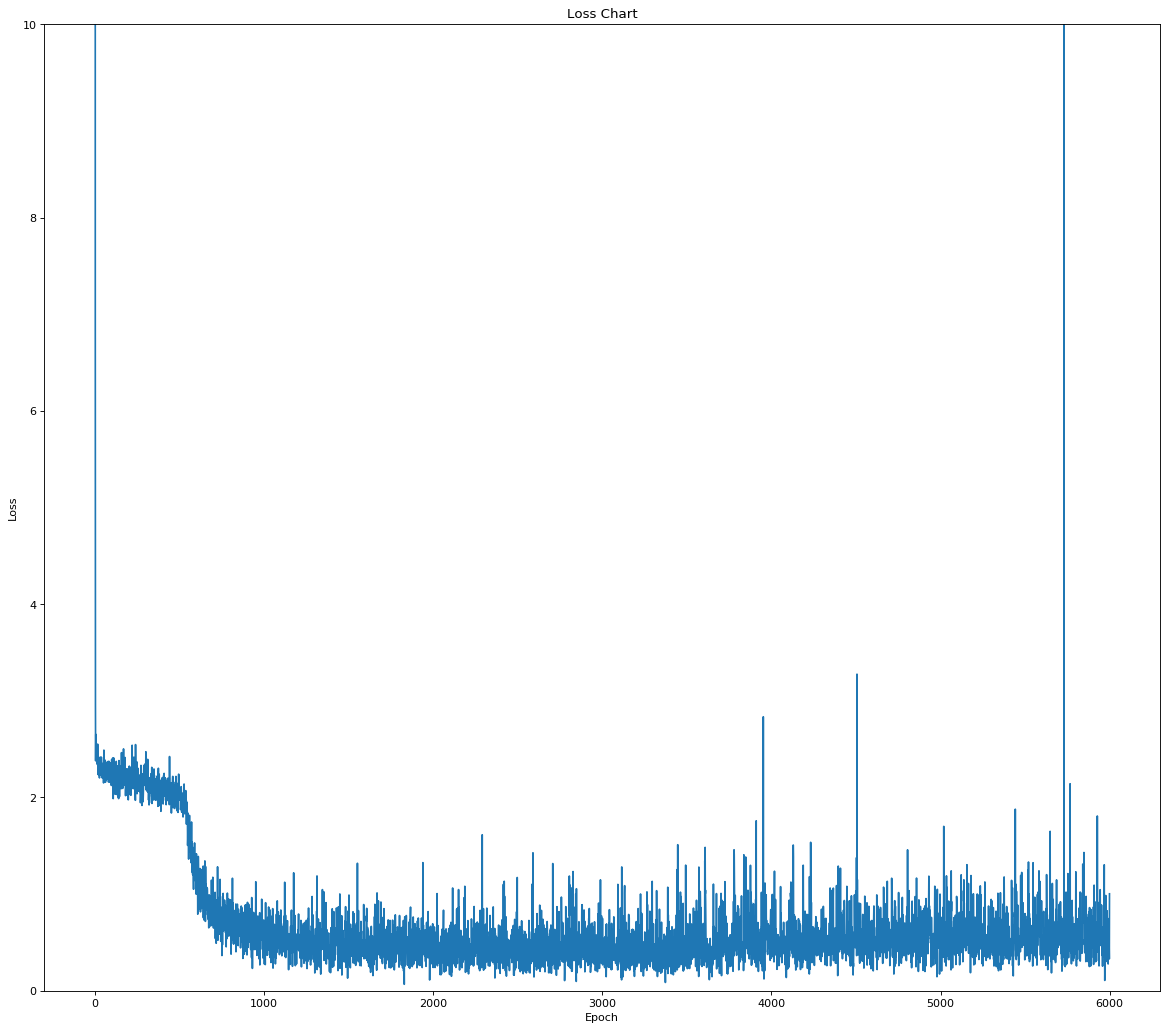

In [34]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim(0,10)
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(plot_data)

In [35]:
outs_ = []
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('seedlings-model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("Placeholder:0")
    for i in range(len(test_data)):
        feed ={x: [test_data[i][0]], hold_prob:1}

        op_to_restore = tf.nn.softmax(graph.get_tensor_by_name("add_3:0"))

        aaa = sess.run(op_to_restore, feed).ravel().tolist()
        aaa = aaa.index(max(aaa))
        print(dirs[aaa])
        outs_.append([test_data[i][1], dirs[aaa]])

INFO:tensorflow:Restoring parameters from ./seedlings-model.ckpt
Cleavers
Cleavers
Small-flowered Cranesbill
Charlock
Charlock
Loose Silky-bent
Shepherds Purse
Cleavers
Charlock
Maize
Charlock
Fat Hen
Charlock
Charlock
Cleavers
Cleavers
Sugar beet
Sugar beet
Cleavers
Charlock
Charlock
Charlock
Loose Silky-bent
Cleavers
Cleavers
Maize
Charlock
Charlock
Small-flowered Cranesbill
Cleavers
Cleavers
Small-flowered Cranesbill
Charlock
Charlock
Loose Silky-bent
Cleavers
Charlock
Cleavers
Cleavers
Sugar beet
Cleavers
Cleavers
Cleavers
Charlock
Maize
Charlock
Fat Hen
Small-flowered Cranesbill
Cleavers
Sugar beet
Sugar beet
Charlock
Fat Hen
Maize
Charlock
Sugar beet
Charlock
Sugar beet
Charlock
Cleavers
Common wheat
Maize
Loose Silky-bent
Loose Silky-bent
Charlock
Charlock
Fat Hen
Cleavers
Small-flowered Cranesbill
Cleavers
Maize
Cleavers
Charlock
Fat Hen
Black-grass
Cleavers
Cleavers
Cleavers
Loose Silky-bent
Small-flowered Cranesbill
Cleavers
Charlock
Cleavers
Fat Hen
Charlock
Small-flowered C

Charlock
Fat Hen
Sugar beet
Loose Silky-bent
Loose Silky-bent
Charlock
Loose Silky-bent
Charlock
Fat Hen
Fat Hen
Sugar beet
Loose Silky-bent
Cleavers
Small-flowered Cranesbill
Cleavers
Cleavers
Common wheat
Cleavers
Shepherds Purse
Small-flowered Cranesbill
Cleavers
Cleavers
Small-flowered Cranesbill
Cleavers
Fat Hen
Charlock
Cleavers
Loose Silky-bent
Loose Silky-bent
Charlock
Small-flowered Cranesbill
Loose Silky-bent
Common wheat
Fat Hen
Loose Silky-bent
Charlock
Charlock
Charlock
Fat Hen
Small-flowered Cranesbill
Charlock
Charlock
Small-flowered Cranesbill
Fat Hen
Cleavers
Common Chickweed
Loose Silky-bent
Loose Silky-bent
Charlock
Fat Hen
Shepherds Purse
Charlock
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Black-grass
Cleavers
Loose Silky-bent
Cleavers
Maize
Loose Silky-bent
Cleavers
Charlock
Cleavers
Fat Hen
Cleavers
Cleavers
Cleavers
Charlock
Small-flowered Cranesbill
Common wheat
Fat Hen
Charlock
Cleavers
Charlock
Charlock
Shepherds Purse
Common wheat
Charlock
Charlock
Ch

## Writing csv submition

In [36]:
import csv
with open('submition.csv', 'w') as csvfile:
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(outs_)):
        writer.writerow({'file': outs_[i][0], 'species':outs_[i][1]})
    print("csv file ready")

csv file ready
